# Decentralized tunnel passing

In [4]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.tunnels import detect_tunnels

import shapely
import numpy as np
from matplotlib import pyplot as plt

from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely import Polygon,LineString,Point


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

start_locs = np.array([[5,1],[-5,-1]])
goal_locs = np.array([[-5,1],[5,-1]])

starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

In [12]:
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx, interpolate_positions

from panav.env import line_seg_to_obstacle

In [43]:
bloating_r = 0.5

d = 2
K = 10
t0 = 0
vmax = 1.0
interp_dt = 0.1

In [44]:
agents = np.arange(len(starts))
ts = []
xs = []
for go_agent in agents:
    start = env.starts[go_agent]
    goal = env.goals[go_agent]
    t,x = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                     [],\
                                    d,K,t0)
    t,x = unique_tx(t,x)
    ts.append(t)
    xs.append(x)

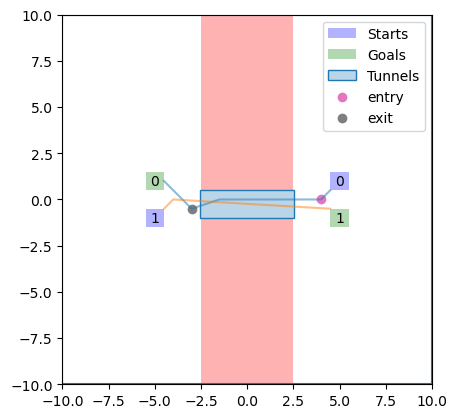

In [57]:

ax = plt.gca()


draw_env(env,xs,ax)

# plot_line(face,ax=ax)
labeled = False
tunnels = detect_tunnels(env,bloating_r)
for tunnel in tunnels:
    plot_polygon(tunnel.region,ax=ax,label='Tunnels' if not labeled else None,add_points =False)
    labeled=True

x=xs[0]

tun = tunnels[0]

face_lines = [LineString(f) for f in tun.faces]

entry = []
exit = []

for i in range(x.shape[-1]-1):
    seg = LineString((x[:,i],x[:,i+1]))
    for fid, fl in enumerate(face_lines):
        if seg.intersects(fl):
            ent_sgn = np.sign(tun.perps[fid].dot(x[:,i+1]-x[:,i]))
            # print(fid,ent_sgn)
            if ent_sgn == 1:
                entry = x[:,i]
            elif ent_sgn == -1:
                exit = x[:,i+1]
        

plt.scatter(entry[0],entry[1],label='entry')
plt.scatter(exit[0],exit[1],label='exit')


plt.legend()
plt.show()

# Items

Tunnel class. Single tunnel.
1. region: shapely polygon
2. freefaces: shapely linestrings, faces of the polygon that does not intersect with any obstacles or other tunnels(require a list of tunnel objects)
3. passage: {(free face id1, free face id2): waitlist, passinglist}
4. Method: inout(waypoint1, waypoint2, freeface): output 0 if wp1-wp2 does not intersect with free face. -1 if wp1-wp2 comes out the tunnel. +1 if goes into the tunnel. Determine +-1 using the perp vector of freeface.
5. Method: get_passage(PWL of the agent). Return the corresponding waitlist and passing list.

PWL of the agent:

some segments of the PWL are marked as hard, other soft. Hard segments go through a tunnel/a connected tunnel network. Hard segments starts with a wait wp, the agent should wait at this wp before enter the tunnel/tunnel network.

AttributeError: 'Tunnel' object has no attribute 'exterior'

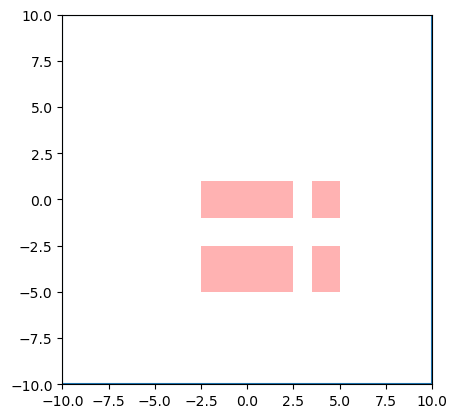

In [40]:
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

o1 = Box2DRegion((-2.5,2.5),(-1.0,1.0))
o2 = Box2DRegion((-2.5,2.5),(-5,-2.5))

o3 = Box2DRegion((3.5,5),(-5,-2.5))

o4 = Box2DRegion((3.5,5),(-1.0,1.0))

obstacles = [o1,o2,o3,o4]

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,obstacles,[],[])

ax = plt.gca()

draw_env(env,ax=ax)
        

labeled = False
tunnels = detect_tunnels(env,bloating_r)
for tunnel in tunnels:
    plot_polygon(tunnel,ax=ax,label='Tunnels' if not labeled else None,add_points =False)
    labeled=True
    
ax.legend()
plt.show()